In [1]:
# https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'CRNN'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../Datasets/IHR-NomDB'
LABELS_PATH = r'../Datasets/IHR-NomDB/labels.txt'
FONT_PATH = r'../../NomNaTong-Regular.ttf'

## Load and remove records with rare characters 

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
BATCH_SIZE = 32

In [6]:
from loader import DataHandler
data_handler = DataHandler(dataset, img_size=(HEIGHT, WIDTH), padding_char=PADDING_CHAR)
VOCAB_SIZE = data_handler.char2num.vocab_size()

## Visualize the data

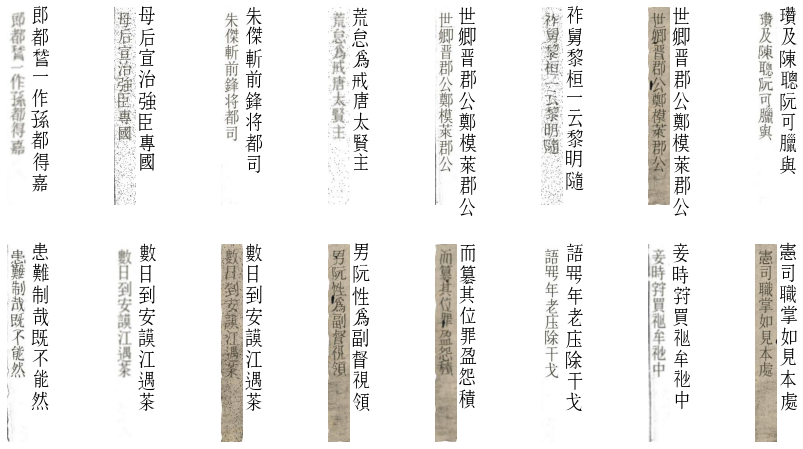

In [7]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    font_path = FONT_PATH, 
    text_x = WIDTH + 3
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from layers import custom_cnn, reshape_features

In [9]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 
            
            # Last Conv blocks with 2x2 kernel but without padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN
    feature_maps = reshape_features(x, dim_to_keep=1, name='rnn_input')
    
    # RNN layers
    bigru1 = Bidirectional(GRU(256, return_sequences=True), name='bigru1')(feature_maps)
    bigru2 = Bidirectional(GRU(256, return_sequences=True), name='bigru2')(bigru1)
    
    # Output layer
    y_pred = Dense(
        units = VOCAB_SIZE + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(bigru2)
    return Model(inputs=image_input, outputs=y_pred, name=name)

In [10]:
from models import get_imagenet_model
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 3))
# imagenet_output_layer = 'block5_pool'
# imagenet_model.summary(line_length=100)

In [11]:
model = build_crnn(imagenet_model, imagenet_output_layer)
model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 image (InputLayer)                              [(None, 432, 48, 3)]                        0                
                                                                                                              
 block1_conv1 (Conv2D)                           (None, 432, 48, 64)                         1792             
                                                                                                              
 block1_bn1 (BatchNormalization)                 (None, 432, 48, 64)                         256              
                                                                                                              
 block1_relu1 (Activation)                       (None, 432, 48, 64)                         0    

# Training

In [12]:
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 81226
Number of validate samples: 20307


In [13]:
import random
random.seed(2022)
random.shuffle(train_idxs)

# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE)

## Callbacks

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 1e-3, # Change that less than 1e-3, will count as no improvement
    patience = 5, # Stop if no improvement after 5 epochs
    restore_best_weights = True, # Restore weights from the epoch with the best value
    verbose = 1
)

## Train the IHR-NomDB dataset

In [15]:
from losses import CTCLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adadelta

# Adadelta tends to benefit from higher initial learning rate values compared to
# other optimizers. Here use 1.0 to match the exact form in the original paper
LEARNING_RATE = 1.0
EPOCHS = 100

In [16]:
model.compile(
    optimizer = Adadelta(LEARNING_RATE), 
    loss = CTCLoss(), 
    metrics = [
        SequenceAccuracy(use_ctc_decode=True),
        CharacterAccuracy(use_ctc_decode=True),
        LevenshteinDistance(use_ctc_decode=True, normalize=True)
    ]
)

In [17]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
2539/2539 [==============================] - 368s 142ms/step - loss: 32.3813 - seq_acc: 0.0272 - char_acc: 0.2895 - levenshtein_distance: 0.7067 - val_loss: 23.9715 - val_seq_acc: 0.0096 - val_char_acc: 0.5211 - val_levenshtein_distance: 0.4710
Epoch 2/100
2539/2539 [==============================] - 350s 138ms/step - loss: 10.7599 - seq_acc: 0.2627 - char_acc: 0.7619 - levenshtein_distance: 0.2384 - val_loss: 8.9782 - val_seq_acc: 0.2802 - val_char_acc: 0.8450 - val_levenshtein_distance: 0.1525
Epoch 3/100
2539/2539 [==============================] - 351s 138ms/step - loss: 6.3345 - seq_acc: 0.4708 - char_acc: 0.8667 - levenshtein_distance: 0.1352 - val_loss: 6.1707 - val_seq_acc: 0.4318 - val_char_acc: 0.8958 - val_levenshtein_distance: 0.1016
Epoch 4/100
2539/2539 [==============================] - 352s 139ms/step - loss: 4.4252 - seq_acc: 0.5966 - char_acc: 0.9084 - levenshtein_distance: 0.0942 - val_loss: 4.0732 - val_seq_acc: 0.5866 - val_char_acc: 0.9328 - val_levens

Epoch 33/100
2539/2539 [==============================] - 354s 139ms/step - loss: 0.1083 - seq_acc: 0.9985 - char_acc: 0.9997 - levenshtein_distance: 2.4263e-04 - val_loss: 0.7239 - val_seq_acc: 0.9030 - val_char_acc: 0.9876 - val_levenshtein_distance: 0.0121
Epoch 34/100
2539/2539 [==============================] - 352s 139ms/step - loss: 0.0967 - seq_acc: 0.9988 - char_acc: 0.9998 - levenshtein_distance: 1.8818e-04 - val_loss: 0.7169 - val_seq_acc: 0.9041 - val_char_acc: 0.9877 - val_levenshtein_distance: 0.0121
Epoch 35/100
2539/2539 [==============================] - 348s 137ms/step - loss: 0.0875 - seq_acc: 0.9989 - char_acc: 0.9998 - levenshtein_distance: 1.7667e-04 - val_loss: 0.7095 - val_seq_acc: 0.9045 - val_char_acc: 0.9877 - val_levenshtein_distance: 0.0119
Epoch 36/100
2539/2539 [==============================] - 347s 137ms/step - loss: 0.0790 - seq_acc: 0.9990 - char_acc: 0.9998 - levenshtein_distance: 1.6207e-04 - val_loss: 0.7063 - val_seq_acc: 0.9046 - val_char_acc: 0.

## Save the training results

In [18]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_levenshtein_distance"][best_epoch]}')

- Loss on validation	: 0.6146054267883301
- Sequence accuracy	: 0.9150046706199646
- Character accuracy	: 0.989206850528717
- Levenshtein distance	: 0.010576006025075912


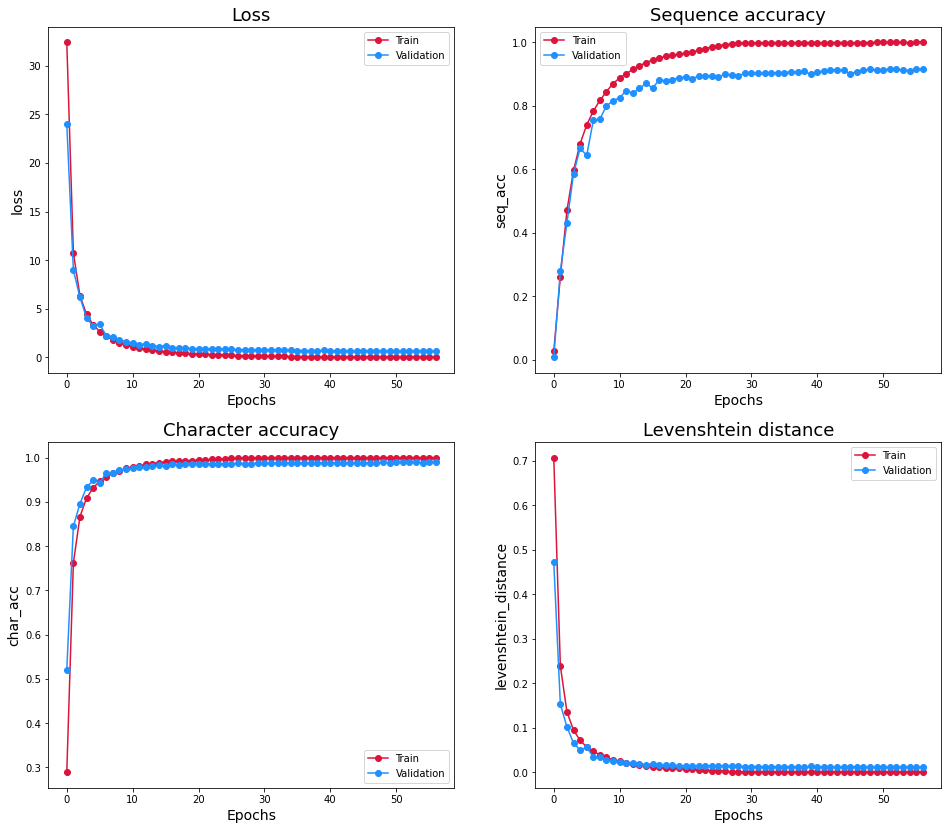

In [19]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.save_weights(f'{APPROACH_NAME}.h5')

# Inference

In [20]:
reset_model = build_crnn(imagenet_model, imagenet_output_layer)
reset_model.load_weights(f'{APPROACH_NAME}.h5')
reset_model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 image (InputLayer)                              [(None, 432, 48, 3)]                        0                
                                                                                                              
 block1_conv1 (Conv2D)                           (None, 432, 48, 64)                         1792             
                                                                                                              
 block1_bn1 (BatchNormalization)                 (None, 432, 48, 64)                         256              
                                                                                                              
 block1_relu1 (Activation)                       (None, 432, 48, 64)                         0    

In [21]:
reset_model.compile(
    optimizer = Adadelta(LEARNING_RATE), 
    loss = CTCLoss(), 
    metrics = [
        SequenceAccuracy(use_ctc_decode=True),
        CharacterAccuracy(use_ctc_decode=True),
        LevenshteinDistance(use_ctc_decode=True, normalize=True)
    ]
)
reset_model.evaluate(valid_tf_dataset)

635/635 [==============================] - 50s 76ms/step - loss: 0.6146 - seq_acc: 0.9150 - char_acc: 0.9892 - levenshtein_distance: 0.0106


[0.6146054267883301,
 0.9150046706199646,
 0.989206850528717,
 0.010576006025075912]

## On test dataset

1/1 [==============================] - 1s 942ms/step
Batch 01:
- True: {1: '㙋𡉖\U000f0b1f', 2: '噙𠿒', 3: '犝犠', 4: '鉸𨦀', 5: '爲䧺禮公而不委之以兵', 6: '爲䧺禮公而不委之以兵', 7: '是以聖帝明王之治天下', 8: '十一月戊子朔日有食之', 9: '以致敗人事者自古有之', 10: '不名以激年老之固位者', 11: '璉以是不平使人陰殺之', 12: '武郡公令人以象載之及', 13: '武郡公令人以象載之及', 14: '大而三綱五常之道以至', 15: '世人以不常見而異之殊', 16: '如先求皇子而立之以安', 17: '如先求皇子而立之以安', 18: '冬十一月帝得陳暠立之', 19: '中國之人不耐其水土也', 20: '首惡之名為人臣而不知', 21: '爲悅而不知其過之大也', 22: '帝位以副天下臣民之望', 23: '食之是月會試天下士人', 24: '十二月以誕日為建天節', 25: '春正月初二日上以大軍', 26: '取士之科不一而定三年', 27: '取之以賴其後故有是命', 28: '人守之百官進朝不得入', 29: '牧之民不足以煩中國也', 30: '罄家所有以奉事之冀其', 31: '土人以為灵異立祠事之', 32: '土人以為灵異立祠事之'}
- Pred: {1: '堪\U000f01e5玳', 2: '噲𠿁', 3: '輝摓', 4: '鈘𠟲', 5: '爲䧺禮公而不委之以兵', 6: '爲䧺禮公而不委之以兵', 7: '是以聖帝明王之治天下', 8: '十一月戊子朔日有食之', 9: '以致敗人事者自古有之', 10: '不名以激年老之固位者', 11: '璉以是不平使人陰殺之', 12: '武郡公令人以象載之及', 13: '武郡公令人以象載之及', 14: '大而三綱五常之道以至', 15: '世人以不常見而異之\U000f16a4', 16: '如先求皇子而立之以安', 17: '如先求皇子而立之以安', 18: '冬十一月帝得陳暠立之', 19: '中國之人不耐其水土也', 20: '首惡之名為人臣而不知', 21: '爲悅而不知其過之大也', 22: '帝位以副天下臣民之望', 

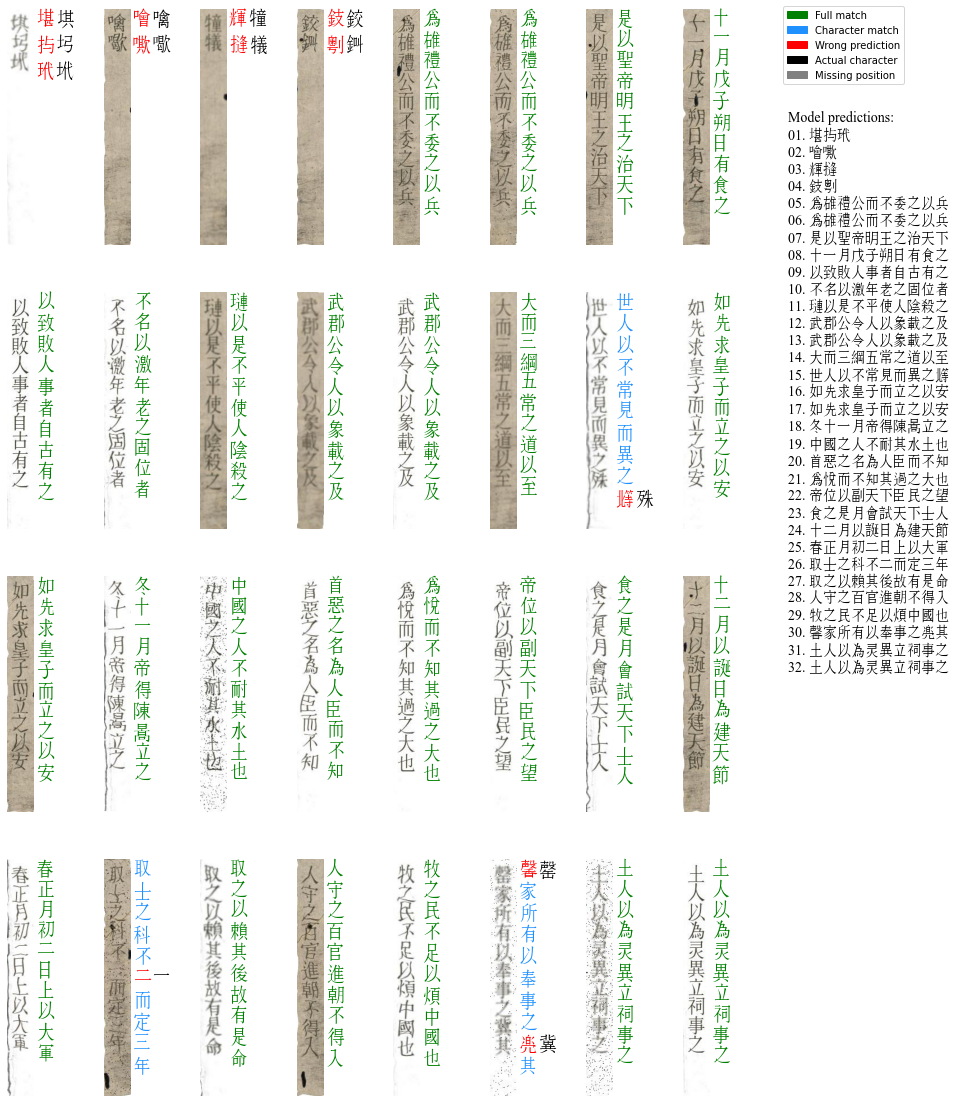

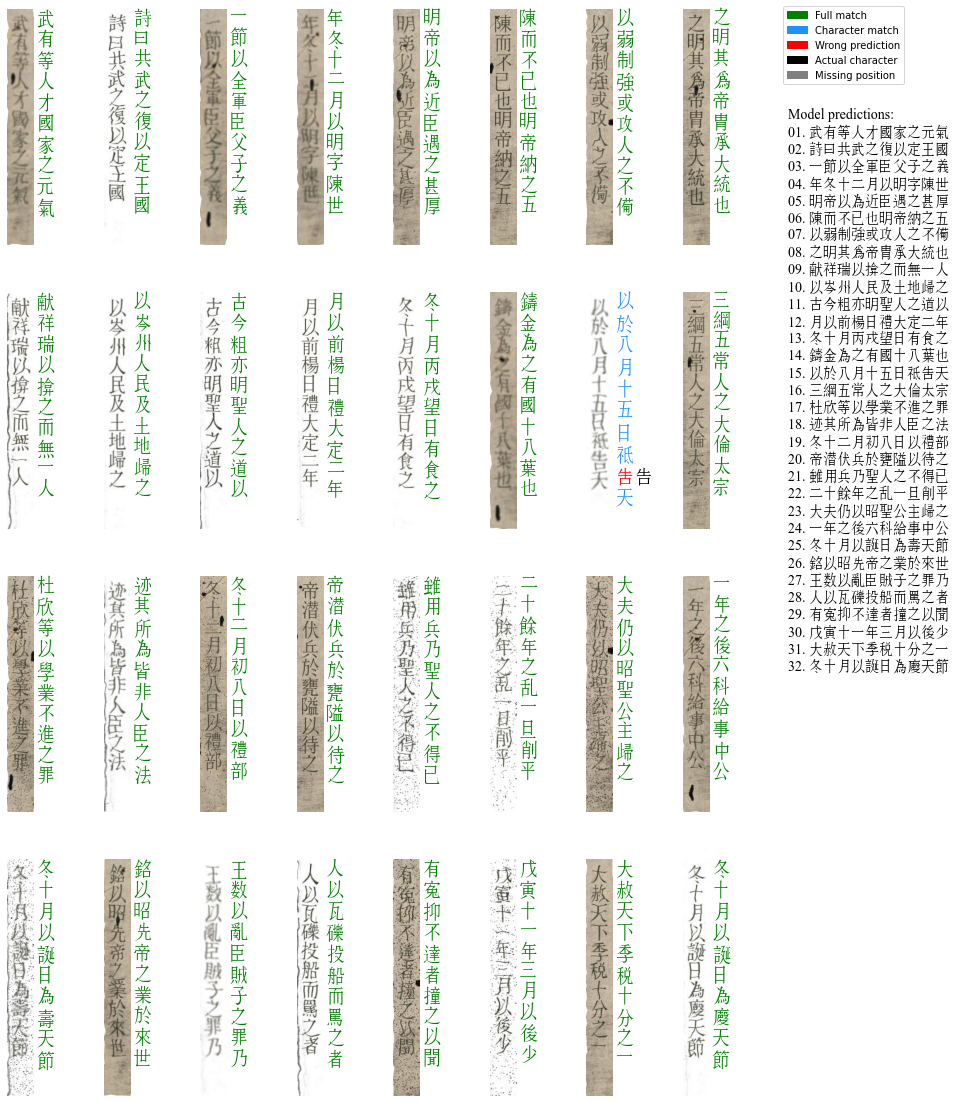

In [22]:
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens = reset_model.predict(batch_images)
    pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)
    
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
        text_x = WIDTH + 5 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [23]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)

1/1 [==============================] - 1s 1s/step


Predicted text: 囷𦝄苔惮󰞺𣈜𦬑囊


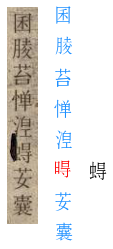

In [24]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
    text_x = WIDTH # Position to plot actual label
)
print('Predicted text:', ''.join(pred_labels))